In [1]:
%pylab inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon, Ellipse
import cmocean.cm as cmo
import gsw

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
savefig = True
figext = '.pdf'
datadir = '/noc/msm/scratch/nemo2/ORCA0083-N001/means_5d/'

degsym = u'\u00B0'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Figures/Fig%s%s' % (fignum, figext)
    if savefig:
        plt.savefig(figname)

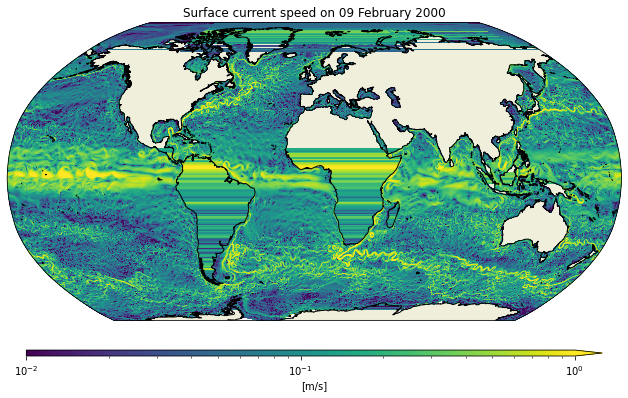

In [3]:
fignum = '04_1'
U = xr.open_mfdataset(datadir+'2000_v3.3.1/ORCA0083-N01_20000105d05U.nc', combine='by_coords').vozocrtx.sel(x=slice(0, 4320))
V = xr.open_mfdataset(datadir+'2000_v3.3.1/ORCA0083-N01_20000105d05V.nc', combine='by_coords').vomecrty.sel(x=slice(0, 4320))
spd = np.hypot(U.isel(depthu=0, time_counter=0), V.isel(depthv=0, time_counter=0))
spd = spd.assign_coords(nav_lat=spd.nav_lat.fillna(0.))
spd = spd.assign_coords(nav_lon=spd.nav_lon.where(spd.nav_lon<74, spd.nav_lon-360))

projection = cartopy.crs.Robinson(central_longitude=0)
fig = plt.figure(figsize=(10, 5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

a = spd.plot(x='nav_lon', y='nav_lat', add_colorbar=False, norm=colors.LogNorm(vmin=0.01, vmax=1),
             transform=cartopy.crs.PlateCarree(), rasterized=True)
plt.title('Surface current speed on %s' % U.time_counter.dt.strftime('%d %B %Y').values[0])

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

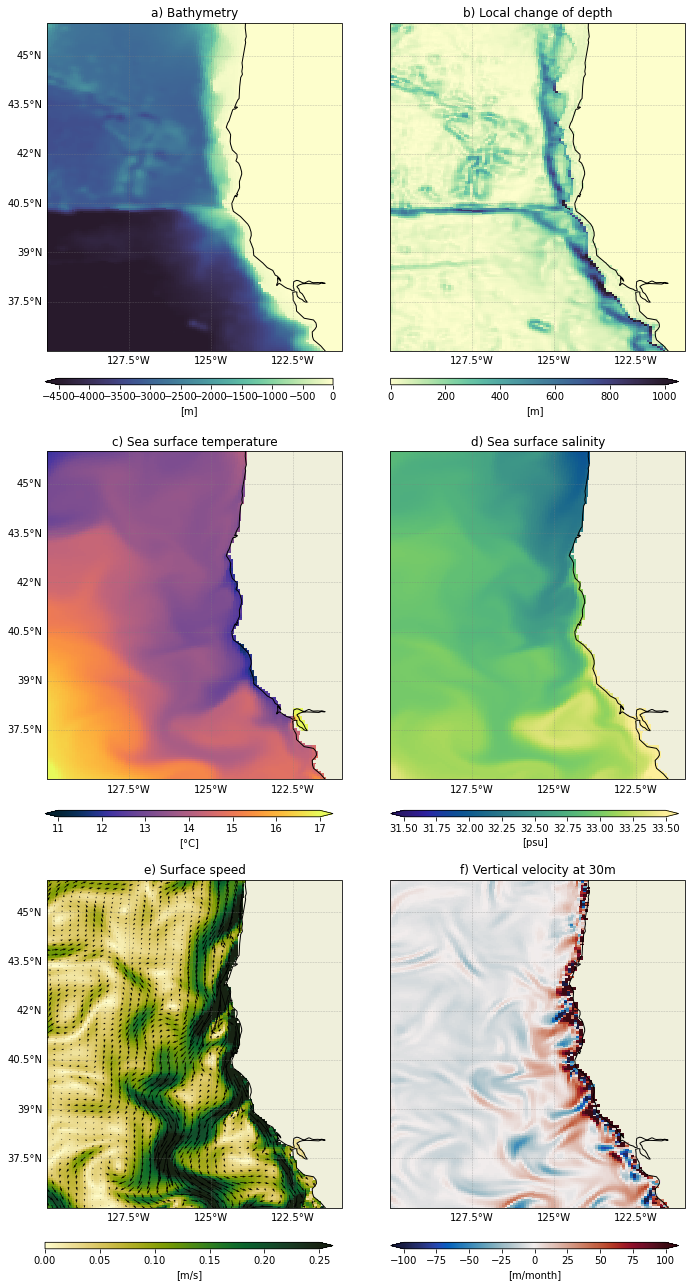

In [4]:
fignum = '05_02'

projection = cartopy.crs.PlateCarree(central_longitude=-125.5)
fig = plt.figure(figsize=(10, 18), constrained_layout=True)
gs = gridspec.GridSpec(6, 2, height_ratios=[7, 1, 7, 1, 7, 1])

for row in range(3):
    for col in range(2):
        i = row*2 + col
        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        ai.set_extent([-130, -121, 36, 46], crs=cartopy.crs.PlateCarree())
        
        if i == 0:
            B = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=slice(1890, 2300), x=slice(1700, 2100)).Bathymetry
            nav_lon = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=slice(1890, 2300), x=slice(1700, 2100)).nav_lon
            nav_lat = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=slice(1890, 2300), x=slice(1700, 2100)).nav_lat
            B = B.assign_coords(nav_lon=nav_lon)
            B = B.assign_coords(nav_lat=nav_lat)
            B = -B
            a = B.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-4500, vmax=0, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.deep_r)
            ai.set_title('a) Bathymetry')
            label, extend = '[m]', 'min'
        if i == 1:
            Bgrad = B.copy()
            Bgrad[:-1, :-1] = np.abs(B[1:, :-1] - B[:-1, :-1]) + np.abs(B[:-1, 1:] - B[:-1, :-1])
            a = Bgrad.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=1000, rasterized=True,
                           transform=cartopy.crs.PlateCarree(), cmap=cmo.deep)
            ai.set_title('b) Local change of depth')
            label, extend = '[m]', 'max'
        if i == 2:
            T = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05T.nc').sel(y=slice(1890, 2300), x=slice(1700, 2100)).votemper
            T = T.isel(deptht=0, time_counter=0)
            a = T.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=11, vmax=17, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.thermal)
            ai.set_title('c) Sea surface temperature')
            label, extend = '[%sC]' %degsym, 'both'
        if i == 3:
            S = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05T.nc').sel(y=slice(1890, 2300), x=slice(1700, 2100)).vosaline.isel(deptht=0, time_counter=0)
            a = S.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=31.5, vmax=33.5, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.haline)
            ai.set_title('d) Sea surface salinity')
            label, extend = '[psu]', 'both'
        if i ==4:
            U = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05U.nc').vozocrtx.sel(y=slice(1890, 2300), x=slice(1700, 2100)).isel(depthu=0, time_counter=0)
            V = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05V.nc').vomecrty.sel(y=slice(1890, 2300), x=slice(1700, 2100)).isel(depthv=0, time_counter=0)
            spd = np.hypot(U, V)
            v = 3
            a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
            ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], U.values[::v, ::v], V.values[::v, ::v], 
                      scale=5, transform=cartopy.crs.PlateCarree())
            ai.set_title('e) Surface speed')
            label, extend = '[m/s]', 'max'
        if i == 5:
            W = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05W.nc').vovecrtz.sel(y=slice(1890, 2300), x=slice(1700, 2100)).sel(depthw=30, method='nearest').isel(time_counter=0)
            W = W * 86400*30  # convert to m/month
            a = W.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-100, vmax=100, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
            ai.set_title('f) Vertical velocity at 30m')
            label, extend = '[m/month]', 'both'

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator(np.arange(-130, -120, 2.5))
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

        acol = 0.07 if col == 0 else 0.55            
        cbaxes = fig.add_axes([acol, 0.7-(row/3.), 0.8/2, 0.005])
        plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend=extend, label=label)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)    

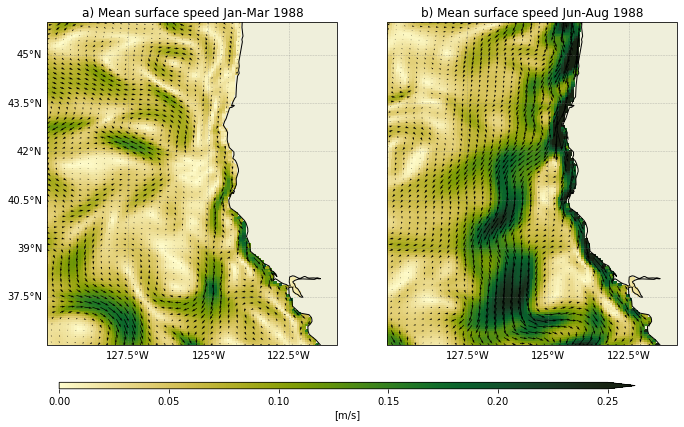

In [5]:
fignum = '05_03'

mons = ['0[1-3]', '0[6-8]']
projection = cartopy.crs.PlateCarree(central_longitude=-125.5)
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[7, 1])

titles = ['a) Mean surface speed Jan-Mar 1988', 'b) Mean surface speed Jun-Aug 1988']
v = 3  # quiver resolution

for i in range(2):
    ai = fig.add_subplot(gs[i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    U = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988%s*d05U.nc' %mons[i], combine='by_coords').vozocrtx.isel(depthu=0)
    V = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988%s*d05V.nc' %mons[i], combine='by_coords').vomecrty.isel(depthv=0)
    U = U.sel(y=slice(1890, 2300), x=slice(1700, 2100)).mean('time_counter')
    V = V.sel(y=slice(1890, 2300), x=slice(1700, 2100)).mean('time_counter')
    spd = np.hypot(U, V)
    
    a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                 transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
    ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], U.values[::v, ::v], V.values[::v, ::v], 
              scale=5, transform=cartopy.crs.PlateCarree())
    ai.set_extent([-130, -121, 36, 46], crs=cartopy.crs.PlateCarree())

    ai.set_title(titles[i])
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-130, -120, 2.5))
    gl.xlabels_bottom = True
    gl.xformatter = LONGITUDE_FORMATTER
    if i == 0:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

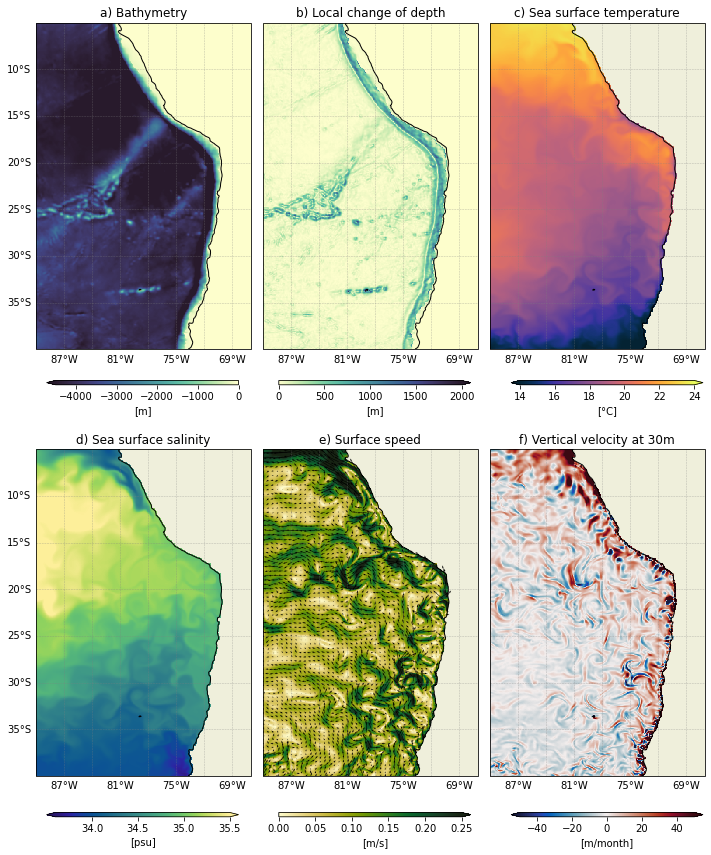

In [6]:
fignum = '05_04'

projection = cartopy.crs.PlateCarree(central_longitude=-125.5)
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
gs = gridspec.GridSpec(4, 3, height_ratios=[7, 1, 7, 1])

yslice = slice(800, 1450)
xslice = slice(2300, 2700)
for row in range(2):
    for col in range(3):
        i = row*3 + col
        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        ai.set_extent([-90, -67, -40, -5], crs=cartopy.crs.PlateCarree())
        
        if i == 0:
            B = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).Bathymetry
            nav_lon = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lon
            nav_lat = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lat
            B = B.assign_coords(nav_lon=nav_lon)
            B = B.assign_coords(nav_lat=nav_lat)
            B = -B
            a = B.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-4500, vmax=0, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.deep_r)
            ai.set_title('a) Bathymetry')
            label, extend = '[m]', 'min'
        if i == 1:
            Bgrad = B.copy()
            Bgrad[:-1, :-1] = np.abs(B[1:, :-1] - B[:-1, :-1]) + np.abs(B[:-1, 1:] - B[:-1, :-1])
            a = Bgrad.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=2000, rasterized=True,
                           transform=cartopy.crs.PlateCarree(), cmap=cmo.deep)
            ai.set_title('b) Local change of depth')
            label, extend = '[m]', 'max'
        if i == 2:
            T = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19881221d05T.nc').sel(y=yslice, x=xslice).votemper
            T = T.isel(deptht=0, time_counter=0)
            a = T.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=14, vmax=24, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.thermal)
            ai.set_title('c) Sea surface temperature')
            label, extend = '[%sC]' %degsym, 'both'
        if i == 3:
            S = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19881221d05T.nc').sel(y=yslice, x=xslice).vosaline.isel(deptht=0, time_counter=0)
            a = S.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=33.6, vmax=35.5, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.haline)
            ai.set_title('d) Sea surface salinity')
            label, extend = '[psu]', 'both'
        if i ==4:
            U = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19881221d05U.nc').vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0, time_counter=0)
            V = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19881221d05V.nc').vomecrty.sel(y=yslice, x=xslice).isel(depthv=0, time_counter=0)
            spd = np.hypot(U, V)
            v = 6
            a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
            ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], U.values[::v, ::v], V.values[::v, ::v], 
                      scale=5, transform=cartopy.crs.PlateCarree())
            ai.set_title('e) Surface speed')
            label, extend = '[m/s]', 'max'
        if i == 5:
            W = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19881221d05W.nc').vovecrtz.sel(y=yslice, x=xslice).sel(depthw=30, method='nearest').isel(time_counter=0)
            W = W * 86400*30  # convert to m/month
            a = W.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-50, vmax=50, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
            ai.set_title('f) Vertical velocity at 30m')
            label, extend = '[m/month]', 'both'

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

        cbaxes = fig.add_axes([0.07+col/3.1, 0.55-(row/2.), 0.8/3, 0.005])
        plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend=extend, label=label)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)  

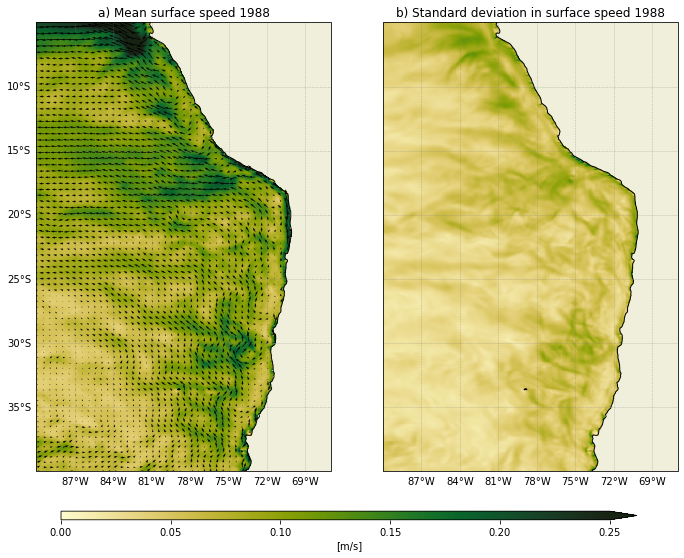

In [7]:
fignum = '05_05'

projection = cartopy.crs.PlateCarree(central_longitude=-125.5)
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[7, 1])

titles = ['a) Mean surface speed 1988', 'b) Standard deviation in surface speed 1988']
v = 6  # quiver resolution
yslice = slice(800, 1450)
xslice = slice(2300, 2700)

for i in range(2):
    ai = fig.add_subplot(gs[i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)

    U = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988*d05U.nc', combine='by_coords').vozocrtx.isel(depthu=0).sel(y=yslice, x=xslice)
    V = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988*d05V.nc', combine='by_coords').vomecrty.isel(depthv=0).sel(y=yslice, x=xslice)
    spd = np.hypot(U, V)

    if i == 0:
        a = spd.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                                          transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], 
                  U.mean('time_counter').values[::v, ::v], V.mean('time_counter').values[::v, ::v],
                  scale=5, transform=cartopy.crs.PlateCarree())
    elif i == 1:
        a = spd.std('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
    ai.set_extent([-90, -67, -40, -5], crs=cartopy.crs.PlateCarree())

    ai.set_title(titles[i])
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_bottom = True
    gl.xformatter = LONGITUDE_FORMATTER
    if i == 0:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

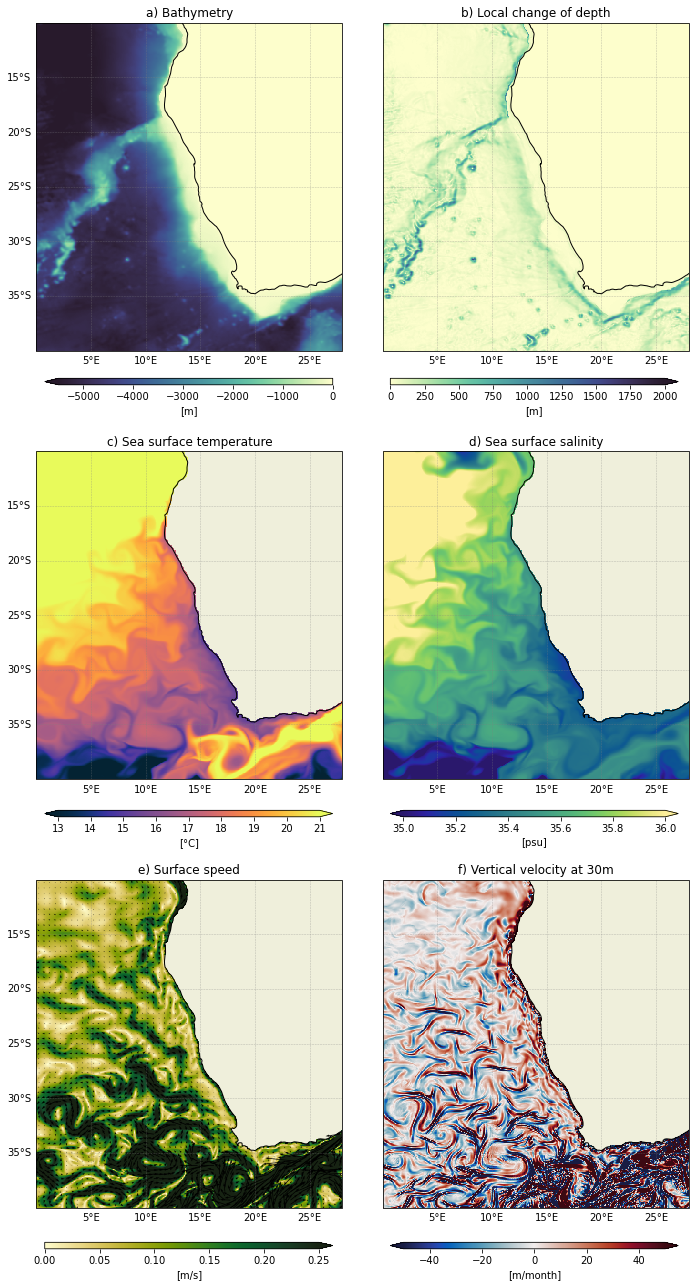

In [8]:
fignum = '05_06'

projection = cartopy.crs.PlateCarree(central_longitude=-125.5)
fig = plt.figure(figsize=(10, 18), constrained_layout=True)
gs = gridspec.GridSpec(6, 2, height_ratios=[7, 1, 7, 1, 7, 1])

yslice = slice(800, 1450)
xslice = slice(3400, 3800)
for row in range(3):
    for col in range(2):
        i = row*2 + col
        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        ai.set_extent([0, 28, -40, -10], crs=cartopy.crs.PlateCarree())
        
        if i == 0:
            B = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).Bathymetry
            nav_lon = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lon
            nav_lat = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lat
            B = B.assign_coords(nav_lon=nav_lon)
            B = B.assign_coords(nav_lat=nav_lat)
            B = -B
            a = B.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-5500, vmax=0, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.deep_r)
            ai.set_title('a) Bathymetry')
            label, extend = '[m]', 'min'
        if i == 1:
            Bgrad = B.copy()
            Bgrad[:-1, :-1] = np.abs(B[1:, :-1] - B[:-1, :-1]) + np.abs(B[:-1, 1:] - B[:-1, :-1])
            a = Bgrad.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=2000, rasterized=True,
                           transform=cartopy.crs.PlateCarree(), cmap=cmo.deep)
            ai.set_title('b) Local change of depth')
            label, extend = '[m]', 'max'
        if i == 2:
            T = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05T.nc').sel(y=yslice, x=xslice).votemper
            T = T.isel(deptht=0, time_counter=0)
            a = T.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=13, vmax=21, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.thermal)
            ai.set_title('c) Sea surface temperature')
            label, extend = '[%sC]' %degsym, 'both'
        if i == 3:
            S = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05T.nc').sel(y=yslice, x=xslice).vosaline.isel(deptht=0, time_counter=0)
            a = S.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=35, vmax=36, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.haline)
            ai.set_title('d) Sea surface salinity')
            label, extend = '[psu]', 'both'
        if i ==4:
            U = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05U.nc').vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0, time_counter=0)
            V = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05V.nc').vomecrty.sel(y=yslice, x=xslice).isel(depthv=0, time_counter=0)
            spd = np.hypot(U, V)
            v = 6
            a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
            ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], U.values[::v, ::v], V.values[::v, ::v], 
                      scale=15, transform=cartopy.crs.PlateCarree())
            ai.set_title('e) Surface speed')
            label, extend = '[m/s]', 'max'
        if i == 5:
            W = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05W.nc').vovecrtz.sel(y=yslice, x=xslice).sel(depthw=30, method='nearest').isel(time_counter=0)
            W = W * 86400*30  # convert to m/month
            a = W.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-50, vmax=50, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
            ai.set_title('f) Vertical velocity at 30m')
            label, extend = '[m/month]', 'both'

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

        acol = 0.07 if col == 0 else 0.55            
        cbaxes = fig.add_axes([acol, 0.7-(row/3.), 0.8/2, 0.005])
        plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend=extend, label=label)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)    

<xarray.DataArray 'nav_lon' ()>
array(-28.752726, dtype=float32) <xarray.DataArray 'nav_lon' ()>
array(-3.6991062, dtype=float32)
<xarray.DataArray 'nav_lat' ()>
array(0.49999365, dtype=float32) <xarray.DataArray 'nav_lat' ()>
array(38.85047, dtype=float32)


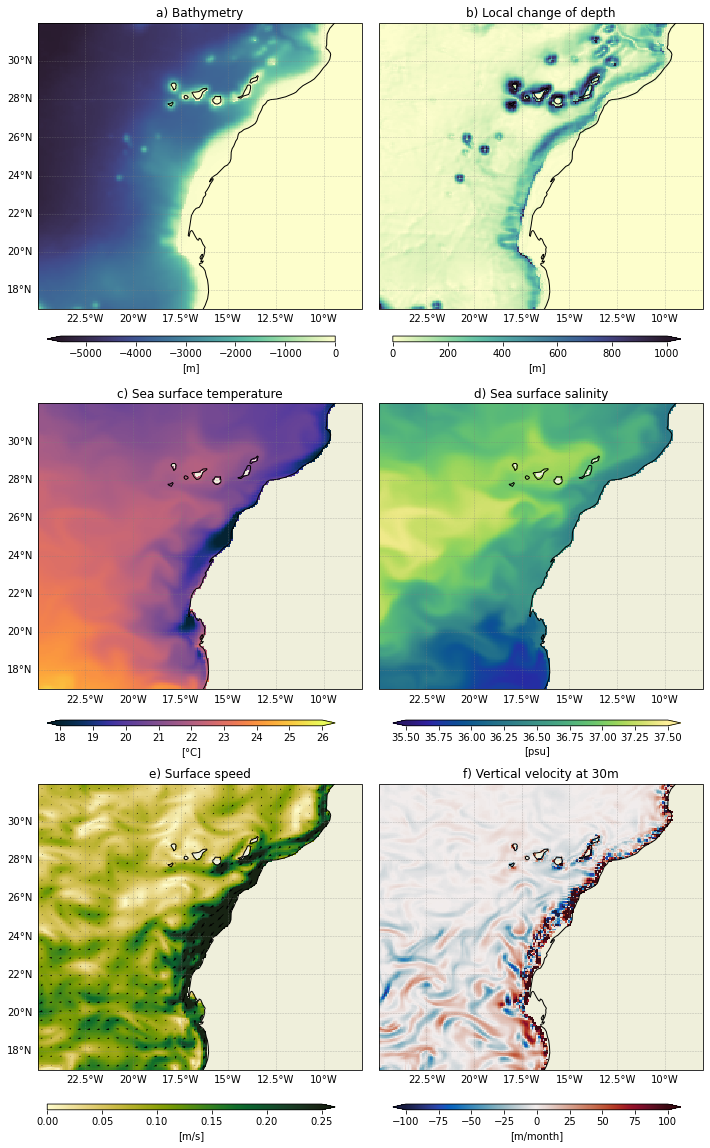

In [9]:
fignum = '05_07'

projection = cartopy.crs.PlateCarree(central_longitude=-125.5)
fig = plt.figure(figsize=(10, 16), constrained_layout=True)
gs = gridspec.GridSpec(6, 2, height_ratios=[7, 1, 7, 1, 7, 1])

yslice = slice(1500, 2000)
xslice = slice(3100, 3400)
for row in range(3):
    for col in range(2):
        i = row*2 + col
        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        ai.set_extent([-25, -8, 17, 32], crs=cartopy.crs.PlateCarree())
        
        if i == 0:
            B = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).Bathymetry
            nav_lon = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lon
            nav_lat = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lat
            B = B.assign_coords(nav_lon=nav_lon)
            B = B.assign_coords(nav_lat=nav_lat)
            print(np.amin(nav_lon), np.amax(nav_lon))
            print(np.amin(nav_lat), np.amax(nav_lat))
            B = -B
            a = B.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-5500, vmax=0, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.deep_r)
            ai.set_title('a) Bathymetry')
            label, extend = '[m]', 'min'
        if i == 1:
            Bgrad = B.copy()
            Bgrad[:-1, :-1] = np.abs(B[1:, :-1] - B[:-1, :-1]) + np.abs(B[:-1, 1:] - B[:-1, :-1])
            a = Bgrad.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=1000, rasterized=True,
                           transform=cartopy.crs.PlateCarree(), cmap=cmo.deep)
            ai.set_title('b) Local change of depth')
            label, extend = '[m]', 'max'
        if i == 2:
            T = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05T.nc').sel(y=yslice, x=xslice).votemper
            T = T.isel(deptht=0, time_counter=0)
            a = T.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=18, vmax=26, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.thermal)
            ai.set_title('c) Sea surface temperature')
            label, extend = '[%sC]' %degsym, 'both'
        if i == 3:
            S = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05T.nc').sel(y=yslice, x=xslice).vosaline.isel(deptht=0, time_counter=0)
            a = S.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=35.5, vmax=37.5, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.haline)
            ai.set_title('d) Sea surface salinity')
            label, extend = '[psu]', 'both'
        if i ==4:
            U = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05U.nc').vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0, time_counter=0)
            V = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05V.nc').vomecrty.sel(y=yslice, x=xslice).isel(depthv=0, time_counter=0)
            spd = np.hypot(U, V)
            v = 6
            a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
            ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], U.values[::v, ::v], V.values[::v, ::v], 
                      scale=15, transform=cartopy.crs.PlateCarree())
            ai.set_title('e) Surface speed')
            label, extend = '[m/s]', 'max'
        if i == 5:
            W = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880624d05W.nc').vovecrtz.sel(y=yslice, x=xslice).sel(depthw=30, method='nearest').isel(time_counter=0)
            W = W * 86400*30  # convert to m/month
            a = W.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-100, vmax=100, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
            ai.set_title('f) Vertical velocity at 30m')
            label, extend = '[m/month]', 'both'

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

        acol = 0.07 if col == 0 else 0.55            
        cbaxes = fig.add_axes([acol, 0.7-(row/3.), 0.8/2, 0.005])
        plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend=extend, label=label)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

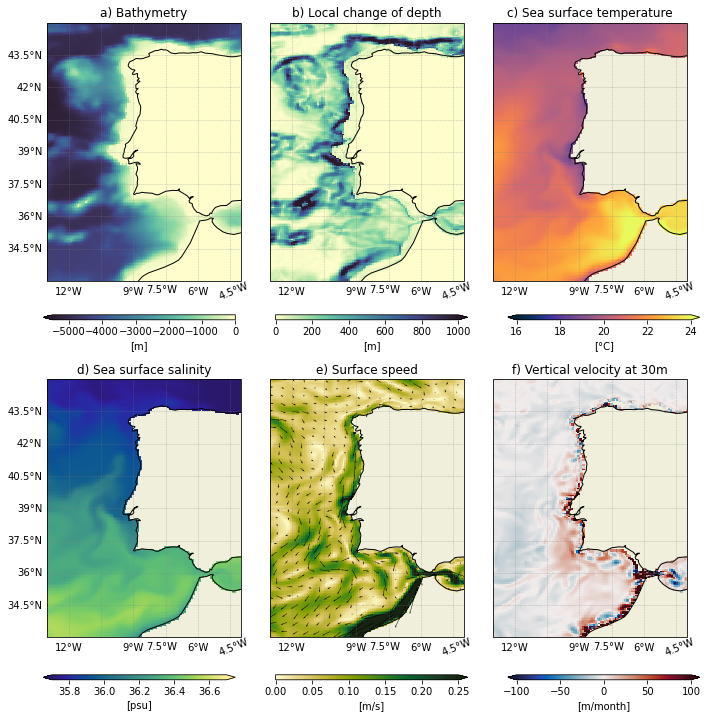

In [10]:
fignum = '05_08'

projection = cartopy.crs.PlateCarree(central_longitude=-9)
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = gridspec.GridSpec(4, 3, height_ratios=[7, 1, 7, 1])

yslice = slice(1900, 2200)
xslice = slice(3100, 3400)
for row in range(2):
    for col in range(3):
        i = row*3 + col
        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        ai.set_extent([-13, -4, 33, 45], crs=cartopy.crs.PlateCarree())
        
        if i == 0:
            B = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).Bathymetry
            nav_lon = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lon
            nav_lat = xr.open_dataset(datadir+'../domain/bathy_meter.nc').sel(y=yslice, x=xslice).nav_lat
            B = B.assign_coords(nav_lon=nav_lon)
            B = B.assign_coords(nav_lat=nav_lat)
            B = -B
            a = B.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-5500, vmax=0, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.deep_r)
            ai.set_title('a) Bathymetry')
            label, extend = '[m]', 'min'
        if i == 1:
            Bgrad = B.copy()
            Bgrad[:-1, :-1] = np.abs(B[1:, :-1] - B[:-1, :-1]) + np.abs(B[:-1, 1:] - B[:-1, :-1])
            a = Bgrad.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=1000, rasterized=True,
                           transform=cartopy.crs.PlateCarree(), cmap=cmo.deep)
            ai.set_title('b) Local change of depth')
            label, extend = '[m]', 'max'
        if i == 2:
            T = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880818d05T.nc').sel(y=yslice, x=xslice).votemper
            T = T.isel(deptht=0, time_counter=0)
            a = T.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=16, vmax=24, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.thermal)
            ai.set_title('c) Sea surface temperature')
            label, extend = '[%sC]' %degsym, 'both'
        if i == 3:
            S = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880818d05T.nc').sel(y=yslice, x=xslice).vosaline.isel(deptht=0, time_counter=0)
            a = S.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=35.7, vmax=36.7, rasterized=True,
                       transform=cartopy.crs.PlateCarree(), cmap=cmo.haline)
            ai.set_title('d) Sea surface salinity')
            label, extend = '[psu]', 'both'
        if i ==4:
            U = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880818d05U.nc').vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0, time_counter=0)
            V = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880818d05V.nc').vomecrty.sel(y=yslice, x=xslice).isel(depthv=0, time_counter=0)
            spd = np.hypot(U, V)
            v = 6
            a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
            ai.quiver(U.nav_lon.values[::v, ::v], U.nav_lat.values[::v, ::v], U.values[::v, ::v], V.values[::v, ::v], 
                      scale=2.5, transform=cartopy.crs.PlateCarree())
            ai.set_title('e) Surface speed')
            label, extend = '[m/s]', 'max'
        if i == 5:
            W = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_19880818d05W.nc').vovecrtz.sel(y=yslice, x=xslice).sel(depthw=30, method='nearest').isel(time_counter=0)
            W = W * 86400*30  # convert to m/month
            a = W.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-100, vmax=100, rasterized=True,
                         transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
            ai.set_title('f) Vertical velocity at 30m')
            label, extend = '[m/month]', 'both'

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator(np.arange(-15, 0, 1.5))
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

        cbaxes = fig.add_axes([0.07+col/3.1, 0.55-(row/2.), 0.8/3, 0.007])
        plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend=extend, label=label)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)  

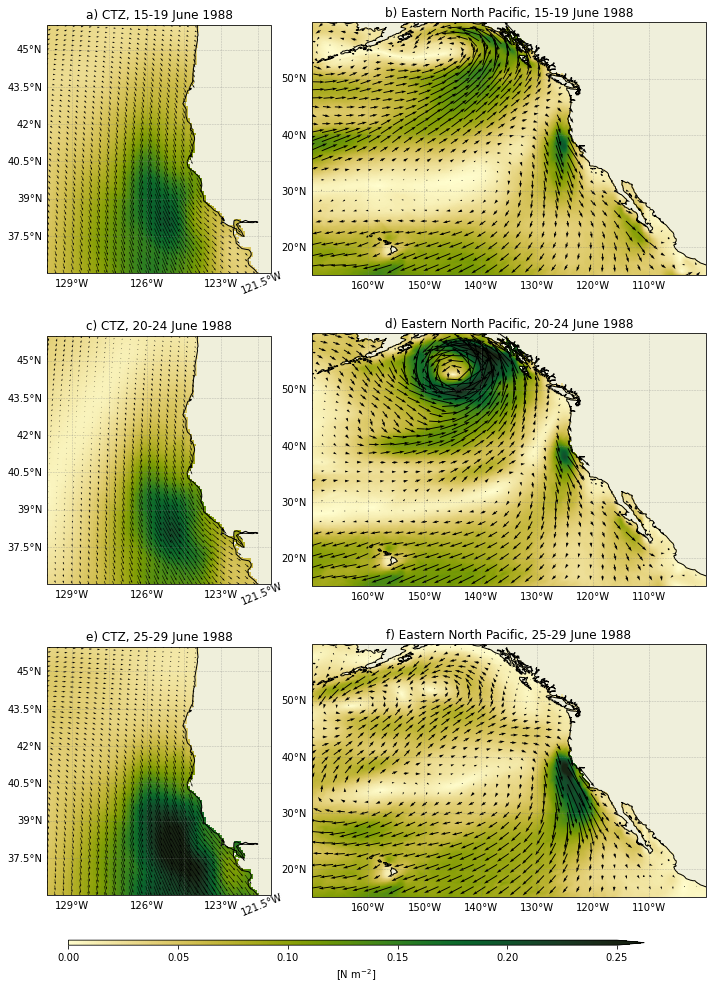

In [11]:
fignum = '05_12'

projection = cartopy.crs.PlateCarree(central_longitude=-125)
fig = plt.figure(figsize=(10, 14), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, height_ratios=[7, 7, 7, 1], width_ratios=[2.5, 4.4])

yslice = [slice(1890, 2300), slice(1500, 3000)]
xslice = [slice(1700, 2100), slice(1300, 2300)]

days = ['19880619', '19880624', '19880629']
regions = ['CTZ', 'Eastern North Pacific']
dstr = ['15-19 June 1988', '20-24 June 1988', '25-29 June 1988']
for row in range(3):
    for col in range(2):
        i = row*2 + col
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        if col == 0:
            ai.set_extent([-130, -121, 36, 46], crs=cartopy.crs.PlateCarree())
        elif col == 1:
            ai.set_extent([-170, -100, 15, 60], crs=cartopy.crs.PlateCarree())

        Tx = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_%sd05U.nc' % days[row]).sozotaux.sel(y=yslice[col], x=xslice[col]).isel(time_counter=0)
        Ty = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_%sd05V.nc' % days[row]).sometauy.sel(y=yslice[col], x=xslice[col]).isel(time_counter=0)
        Tau = np.hypot(Tx, Ty)

        a = Tau.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.25, rasterized=True,
                     transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        v = 4 if col == 0 else 25
        ai.quiver(Tau.nav_lon.values[::v, ::v], Tau.nav_lat.values[::v, ::v], Tx.values[::v, ::v], Ty.values[::v, ::v], 
                  scale=2.5, transform=cartopy.crs.PlateCarree())

        ai.set_title('%s) %s, %s' %(chr(ord('a') + i), regions[col], dstr[row]))
        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.05, 0.8, 0.005])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='max', label='[N m$^{-2}$]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

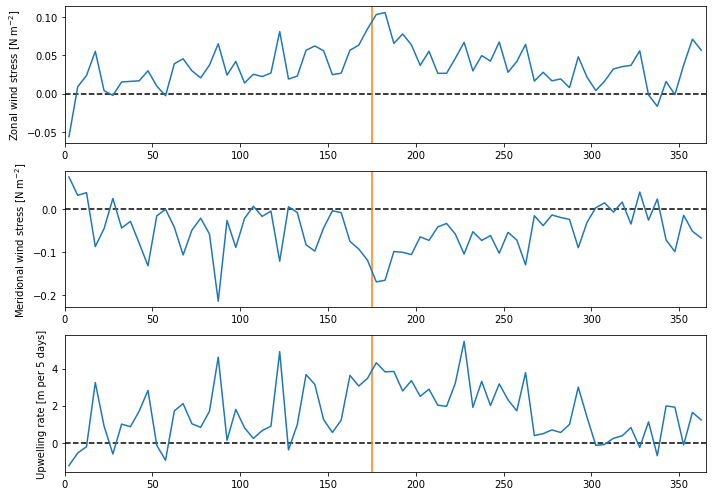

In [12]:
fignum = '05_13'

fig, ax = plt.subplots(3, 1, figsize=(10, 7))

Tx = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988*d05U.nc').sozotaux.isel(y=2012, x=1955)
ax[0].plot(np.arange(2.5, 365, 5), Tx.values)
ax[0].set_ylabel('Zonal wind stress [N m$^{-2}$]')

Ty = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988*d05V.nc').sometauy.isel(y=2012, x=1955)
ax[1].plot(np.arange(2.5, 365, 5), Ty.values)
ax[1].set_ylabel('Meridional wind stress [N m$^{-2}$]')

W = xr.open_mfdataset(datadir+'1988_v3.3.1/ORCA0083-N01_1988*d05W.nc').vovecrtz.sel(y=slice(2000, 2024), x=slice(1943, 1967)).sel(depthw=30, method='nearest')
W = W * 86400*5  # convert to m/5days

ax[2].plot(np.arange(2.5, 365, 5), W.mean('x').mean('y').values)
ax[2].set_ylabel('Upwelling rate [m per 5 days]')

for ai in ax:
    ai.set_xlim([0, 365])
    ai.hlines(0, 0, 365, color='k', linestyle='--')
    yl = ai.get_ylim()
    ai.vlines(35*5, yl[0], yl[1], 'C01')
    ai.set_ylim(yl)

plt.tight_layout()
savefig(fignum)

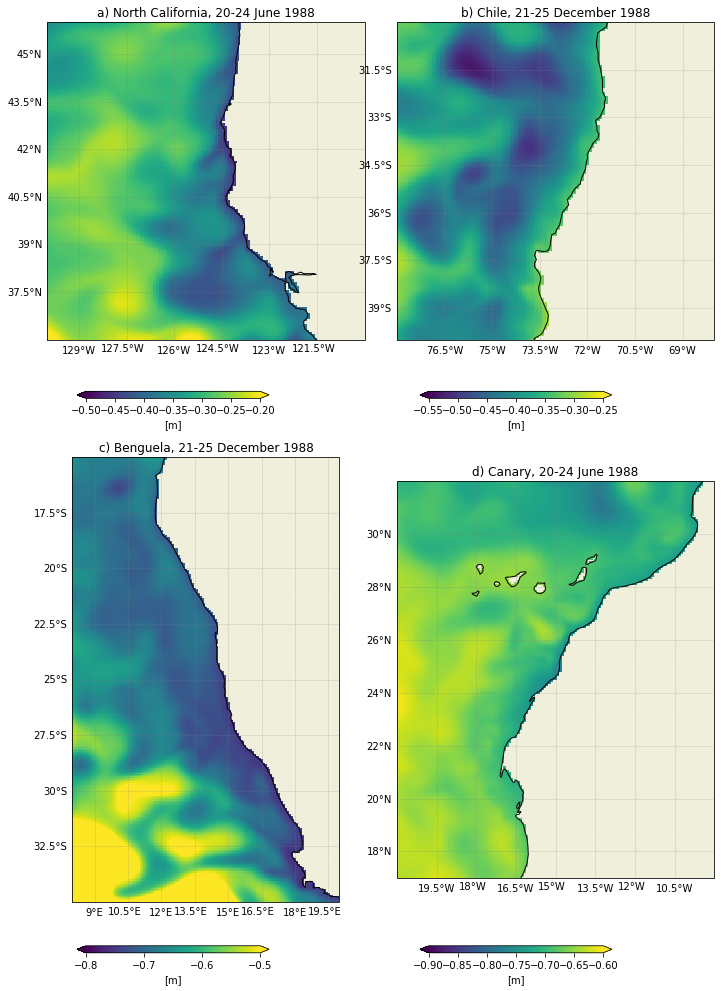

In [13]:
fignum = '05_14'

projection = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(10, 14), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, height_ratios=[5, 1, 7, 1])

yslice = [slice(1890, 2300), slice(800, 1450), slice(800, 1450), slice(1500, 2000)]
xslice = [slice(1700, 2100), slice(2300, 2700), slice(3400, 3800), slice(3100, 3400)]

days = ['19880624', '19881221', '19881221', '19880624']
regions = ['North California', 'Chile', 'Benguela', 'Canary']
dstr = ['20-24 June 1988', '21-25 December 1988', '21-25 December 1988', '20-24 June 1988']
vmin = [-0.50, -0.55, -0.80, -0.90]
for row in range(2):
    for col in range(2):
        i = row*2 + col
        ai = fig.add_subplot(gs[row*2, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        if i == 0:
            ai.set_extent([-130, -120, 36, 46], crs=cartopy.crs.PlateCarree())
        elif i == 1:
            ai.set_extent([-78, -68, -40, -30], crs=cartopy.crs.PlateCarree())
        elif i == 2:
            ai.set_extent([8, 20, -35, -15], crs=cartopy.crs.PlateCarree())
        elif i == 3:
            ai.set_extent([-21, -9, 17, 32], crs=cartopy.crs.PlateCarree())

        S = xr.open_dataset(datadir+'1988_v3.3.1/ORCA0083-N01_%sd05T.nc' % days[row]).sossheig.sel(y=yslice[i], x=xslice[i]).isel(time_counter=0)
        a = S.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=vmin[i], vmax=vmin[i]+0.3, rasterized=True,
                     transform=cartopy.crs.PlateCarree(), cmap=cm.viridis)

        ai.set_title('%s) %s, %s' %(chr(ord('a') + i), regions[i], dstr[i]))
        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

        r = 0.6 if row == 0 else 0.05
        cbaxes = fig.add_axes([0.1+col/2.1, r, 0.8/3, 0.007])
        plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='both', label='[m]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)  

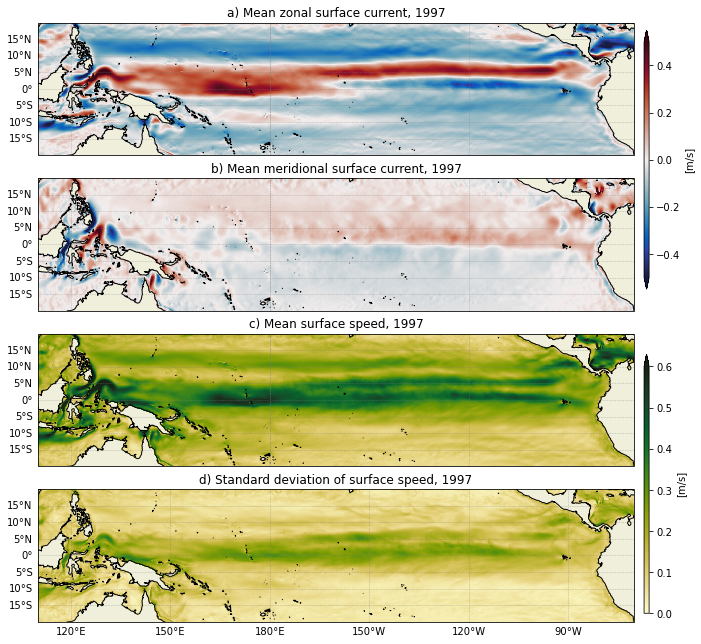

In [14]:
fignum = '06_01'

projection = cartopy.crs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, width_ratios=[10, 1])

yslice = slice(1200, 1800)
xslice = slice(200, 2700)
for row in range(4):
    ai = fig.add_subplot(gs[row, 0], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    ai.set_extent([110, 290, -20, 20], crs=cartopy.crs.PlateCarree())

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')

    if row == 0:
        U = xr.open_mfdataset(datadir+'1997_v3.3.1/ORCA0083-N01_1997*d05U.nc').vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0)
        U = U.assign_coords(nav_lon=(U.nav_lon % 360))
        U = U.assign_coords(nav_lat=U.nav_lat.fillna(0.))
        a = U.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-0.5, vmax=0.5, rasterized=True,
                                        transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
        ai.set_title('a) Mean zonal surface current, 1997')

    if row == 1:
        V = xr.open_mfdataset(datadir+'1997_v3.3.1/ORCA0083-N01_1997*d05V.nc').vomecrty.sel(y=yslice, x=xslice).isel(depthv=0)
        V = V.assign_coords(nav_lon=(V.nav_lon % 360))
        V = V.assign_coords(nav_lat=V.nav_lat.fillna(0.))
        a = V.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-0.5, vmax=0.5, rasterized=True,
                                        transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
        ai.set_title('b) Mean meridional surface current, 1997')

    if row == 2:
        spd = np.hypot(U, V)
        a = spd.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.6, rasterized=True,
                                          transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.set_title('c) Mean surface speed, 1997')
        
    if row ==3:
        a = spd.std('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.6, rasterized=True,
                                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.set_title('d) Standard deviation of surface speed, 1997')
        
        gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, 120, 150, 180])
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER

    if row == 0:
        cbaxes = fig.add_axes([0.9, 0.55, 0.007, 0.4])
        plt.colorbar(a, cax=cbaxes, aspect=50, extend='both', label='[m/s]')
    elif row == 2:
        cbaxes = fig.add_axes([0.9, 0.05, 0.007, 0.4])
        plt.colorbar(a, cax=cbaxes, aspect=50, extend='max', label='[m/s]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

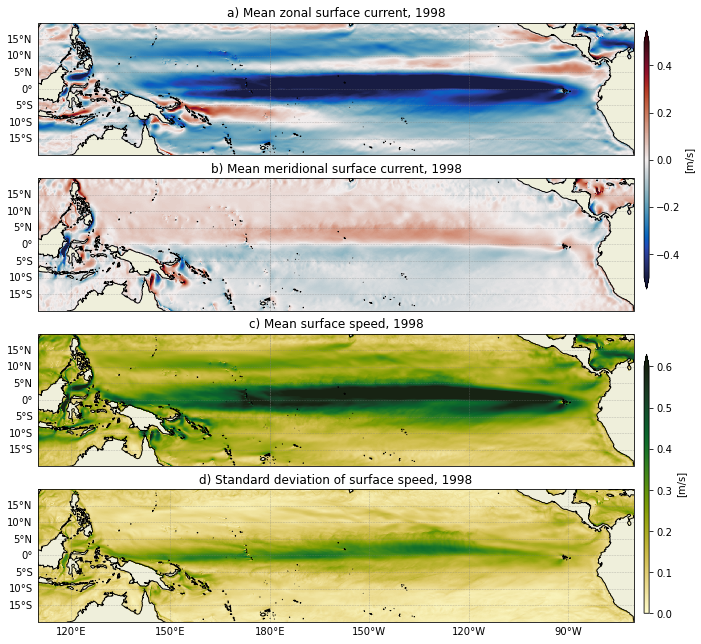

In [15]:
fignum = '06_02'

projection = cartopy.crs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, width_ratios=[10, 1])

yslice = slice(1200, 1800)
xslice = slice(200, 2700)
for row in range(4):
    ai = fig.add_subplot(gs[row, 0], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    ai.set_extent([110, 290, -20, 20], crs=cartopy.crs.PlateCarree())

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')

    if row == 0:
        U = xr.open_mfdataset(datadir+'1998_v3.3.1/ORCA0083-N01_1998*d05U.nc').vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0)
        U = U.assign_coords(nav_lon=(U.nav_lon % 360))
        U = U.assign_coords(nav_lat=U.nav_lat.fillna(0.))
        a = U.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-0.5, vmax=0.5, rasterized=True,
                                        transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
        ai.set_title('a) Mean zonal surface current, 1998')

    if row == 1:
        V = xr.open_mfdataset(datadir+'1998_v3.3.1/ORCA0083-N01_1998*d05V.nc').vomecrty.sel(y=yslice, x=xslice).isel(depthv=0)
        V = V.assign_coords(nav_lon=(V.nav_lon % 360))
        V = V.assign_coords(nav_lat=V.nav_lat.fillna(0.))
        a = V.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-0.5, vmax=0.5, rasterized=True,
                                        transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
        ai.set_title('b) Mean meridional surface current, 1998')

    if row == 2:
        spd = np.hypot(U, V)
        a = spd.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.6, rasterized=True,
                                          transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.set_title('c) Mean surface speed, 1998')
        
    if row ==3:
        a = spd.std('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.6, rasterized=True,
                                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.set_title('d) Standard deviation of surface speed, 1998')
        
        gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, 120, 150, 180])
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER

    if row == 0:
        cbaxes = fig.add_axes([0.9, 0.55, 0.007, 0.4])
        plt.colorbar(a, cax=cbaxes, aspect=50, extend='both', label='[m/s]')
    elif row == 2:
        cbaxes = fig.add_axes([0.9, 0.05, 0.007, 0.4])
        plt.colorbar(a, cax=cbaxes, aspect=50, extend='max', label='[m/s]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

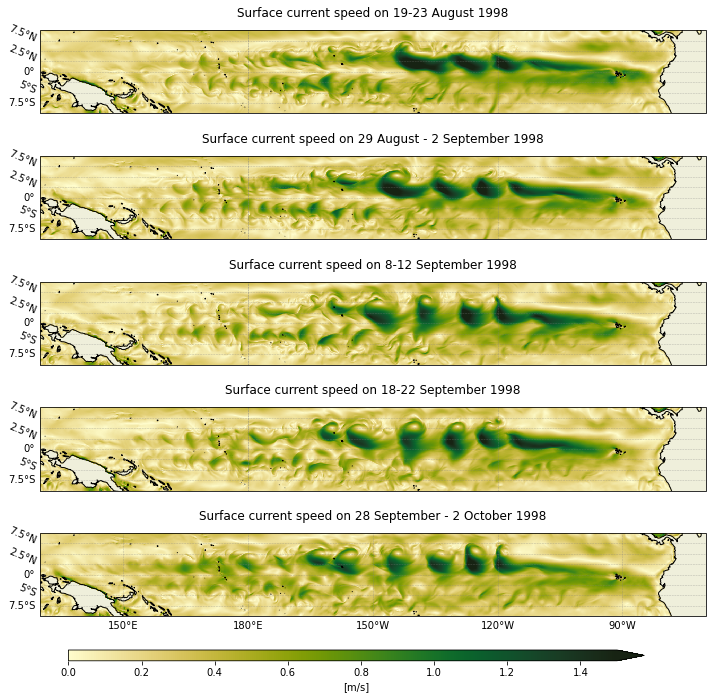

In [16]:
fignum = '06_03'

projection = cartopy.crs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = gridspec.GridSpec(6, 1, height_ratios=[4, 4, 4, 4, 4, 2])

yslice = slice(1300, 1700)
xslice = slice(200, 2700)
days = ['19980818', '19980828', '19980907', '19980917', '19980927']
dstr = ['19-23 August 1998', '29 August - 2 September 1998', '8-12 September 1998', '18-22 September 1998', '28 September - 2 October 1998']

for row in range(5):
    ai = fig.add_subplot(gs[row], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    ai.set_extent([130, 290, -10, 10], crs=cartopy.crs.PlateCarree())
    U = xr.open_dataset(datadir+'1998_v3.3.1/ORCA0083-N01_%sd05U.nc' %days[row]).vozocrtx.sel(y=yslice, x=xslice).isel(depthu=0, time_counter=0)
    V = xr.open_dataset(datadir+'1998_v3.3.1/ORCA0083-N01_%sd05V.nc' %days[row]).vomecrty.sel(y=yslice, x=xslice).isel(depthv=0, time_counter=0)
    spd = np.hypot(U, V)
    spd = spd.assign_coords(nav_lon=(spd.nav_lon % 360))
    spd = spd.assign_coords(nav_lat=spd.nav_lat.fillna(0.))
    a = spd.plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=1.5, rasterized=True,
                 transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
    ai.set_title('Surface current speed on %s' % dstr[row])

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    if row == 4:        
        gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, 120, 150, 180])
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='max', label='[m/s]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

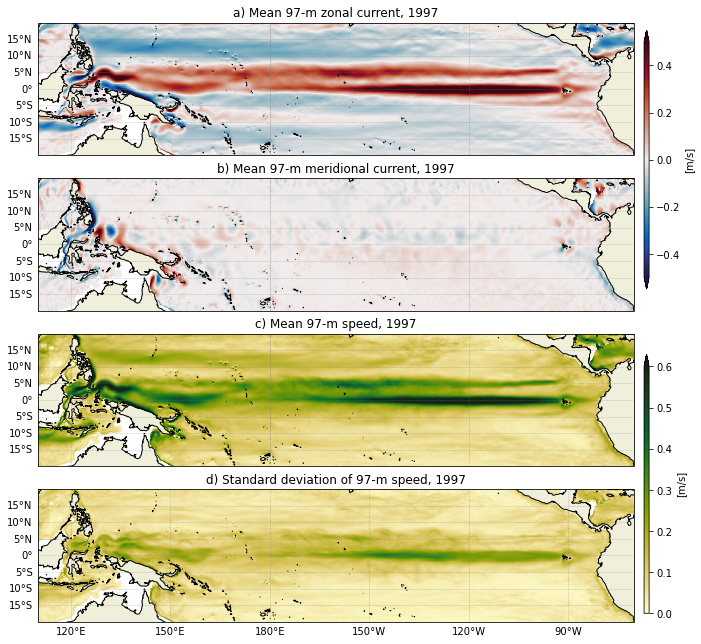

In [17]:
fignum = '06_04'

projection = cartopy.crs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(10, 9), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, width_ratios=[10, 1])

yslice = slice(1200, 1800)
xslice = slice(200, 2700)
for row in range(4):
    ai = fig.add_subplot(gs[row, 0], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    ai.set_extent([110, 290, -20, 20], crs=cartopy.crs.PlateCarree())

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')

    if row == 0:
        U = xr.open_mfdataset(datadir+'1997_v3.3.1/ORCA0083-N01_1997*d05U.nc').vozocrtx.sel(y=yslice, x=xslice).sel(depthu=97, method='nearest')
        U = U.assign_coords(nav_lon=(U.nav_lon % 360))
        U = U.assign_coords(nav_lat=U.nav_lat.fillna(0.))
        a = U.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-0.5, vmax=0.5, rasterized=True,
                                                       transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
        ai.set_title('a) Mean 97-m zonal current, 1997')

    if row == 1:
        V = xr.open_mfdataset(datadir+'1997_v3.3.1/ORCA0083-N01_1997*d05V.nc').vomecrty.sel(y=yslice, x=xslice).sel(depthv=97, method='nearest')
        V = V.assign_coords(nav_lon=(V.nav_lon % 360))
        V = V.assign_coords(nav_lat=V.nav_lat.fillna(0.))
        a = V.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=-0.5, vmax=0.5, rasterized=True,
                                        transform=cartopy.crs.PlateCarree(), cmap=cmo.balance)
        ai.set_title('b) Mean 97-m meridional current, 1997')

    if row == 2:
        spd = np.hypot(U, V)
        a = spd.mean('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.6, rasterized=True,
                                          transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.set_title('c) Mean 97-m speed, 1997')
        
    if row ==3:
        a = spd.std('time_counter').plot(ax=ai, x='nav_lon', y='nav_lat', add_colorbar=False, vmin=0, vmax=0.6, rasterized=True,
                                         transform=cartopy.crs.PlateCarree(), cmap=cmo.speed)
        ai.set_title('d) Standard deviation of 97-m speed, 1997')
        
        gl.xlocator = mticker.FixedLocator([-150, -120, -90, -60, 120, 150, 180])
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER

    if row == 0:
        cbaxes = fig.add_axes([0.9, 0.55, 0.007, 0.4])
        plt.colorbar(a, cax=cbaxes, aspect=50, extend='both', label='[m/s]')
    elif row == 2:
        cbaxes = fig.add_axes([0.9, 0.05, 0.007, 0.4])
        plt.colorbar(a, cax=cbaxes, aspect=50, extend='max', label='[m/s]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)